In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import util

import matplotlib.pyplot as plt
import tensorflow as tf

# MNIST loader

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000, 28, 28, 1)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

train_bf = util.BatchFeeder(X[index[:54000]], Y[index[:54000]], 128)
valid_bf = util.BatchFeeder(X[index[54000:]], Y[index[54000:]], 32)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [21]:
?tf.contrib.slim.fully_connected

# Generative adversarial nets code

In [45]:
class GAN:
    def __init__(self, latent_dim=5):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Define parameters of the encoder
        self.input_dim = (28, 28, 1)
        
        # Dimension of the sub-netowrks.
        self.latent_dim = latent_dim
        self.generator_dim = [128, 64, 32, 1]
        self.discriminator_dim = [32, 64, 128, 1]
        self.batchsize = 128
        self.filtersize = (5,5)
        
        # Activation function is tf.nn.elu
        self.gen_fn = tf.nn.relu
        self.dis_fn = tf.nn.relu
        
        # Other parameters
        self.learning_rate = 0.001
        self.g_lr = 0.002 # 0.0025
        self.d_lr = 0.001 # 1e-5
        
        # Build netowrk
        self.built = False
        self.sesh = tf.Session()
        self.e = 0
        
        # Tracking data
        self.learning_curve = []
        self.record = {"generated":[]}
        
        # Building the graph
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
    
    def build(self):
        # Placeholders for input and dropout probs.
        if self.built:
            return -1
        else:
            self.built = True
        
        x = tf.placeholder(tf.float32, shape=[self.batchsize]+list(self.input_dim), name="x")
        z = tf.random_normal(shape=[self.batchsize, self.latent_dim])
        bn = tf.placeholder(tf.bool, shape=[])
        
        
        # defining G(z)
        gz = self.generator(z, bn)
        
        # making sure that the dimesionality of inputs matches.
        assert gz.shape == x.shape
        
        # defining D(G(z)) and D(x)
        dgz, dgz_pre = self.discriminator(gz, bn)
        dx, dx_pre = self.discriminator(x, bn, reuse=True)
        
        # Compute losses
        d_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dx_pre, labels=tf.ones_like(dx))\
        + tf.nn.sigmoid_cross_entropy_with_logits(logits=dgz_pre, labels=tf.zeros_like(dgz))
        d_loss = tf.reduce_mean(d_loss)
        
        g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dgz_pre, labels=tf.ones_like(dgz))
        g_loss = tf.reduce_mean(g_loss)
        
        # Compute discriminator accuracy
        x_correct = tf.reduce_sum(tf.cast(dx > 0.5, tf.int32))
        z_correct = tf.reduce_sum(tf.cast(dgz < 0.5, tf.int32))
        acc = tf.divide(x_correct + z_correct, 2 * self.batchsize)
        
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            # Define optimizers
            opt_g = tf.train.AdamOptimizer(learning_rate=self.g_lr,beta1=0.5)
            opt_d = tf.train.AdamOptimizer(learning_rate=self.d_lr, beta1=0.5)
            
            # Get weights
            g_vars = [v for v in tf.trainable_variables() if "generator" in v.name]
            d_vars = [v for v in tf.trainable_variables() if "discriminator" in v.name]
            
            # Defining training processs for generator
            grads_and_vars = opt_g.compute_gradients(g_loss, g_vars)
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train_g = opt_g.apply_gradients(clipped, name="minimize_g_loss")
            
            # Defining training processs for generator
            grads_and_vars = opt_d.compute_gradients(d_loss, d_vars)
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train_d = opt_d.apply_gradients(clipped, name="minimize_d_loss")
            
        # Building independent generator
        z_ = tf.placeholder_with_default(tf.random_normal([self.batchsize, self.latent_dim]),
                                            shape=[self.batchsize, self.latent_dim],
                                            name="latent_input")
        gz_ = self.generator(z, bn, reuse=True)
        
        # Exporting out the operaions as dictionary
        return dict(
            x = x,
            z = z,
            generated = gz,
            z_ = z_,
            generated_ = gz_,
            dx = dx,
            dgz = dgz,
            d_loss = d_loss,
            g_loss = g_loss,
            train_d = train_d,
            train_g = train_g,
            acc = acc,
            bn = bn
        )
    
    def discriminator(self, _input, bn, reuse=None):
        with tf.variable_scope("discriminator", reuse=reuse):
            
            # layer 1
            n_filt = 64 #self.discriminator_dim[0]
            layer1 = tf.layers.conv2d(_input, n_filt, self.filtersize, strides=(2,2), padding="same", activation=None)
            layer1 = tf.contrib.layers.batch_norm(layer1, is_training=bn)
            layer1 = self.dis_fn(layer1)
            
            # layer 2
            n_filt = 128 #self.discriminator_dim[1]
            layer2 = tf.layers.conv2d(layer1, n_filt, self.filtersize, strides=(2,2), padding="same", activation=None)
            layer2 = tf.contrib.layers.batch_norm(layer2, is_training=bn)
            layer2 = self.dis_fn(layer2)
            
            # layer 3
            n_filt = 256 #self.discriminator_dim[1]
            layer3 = tf.layers.conv2d(layer2, n_filt, self.filtersize, strides=(2,2), padding="same", activation=None)
            layer3 = tf.contrib.layers.batch_norm(layer3, is_training=bn)
            layer3 = self.dis_fn(layer3)
            
            # Dense to output
            layer4 = tf.layers.flatten(layer3)
            layer4 = tf.contrib.slim.fully_connected(layer4, 1, activation_fn=None)
            output = tf.nn.sigmoid(layer4)
            
            print "===D==="
            print layer1
            print layer2
            print layer3
            print layer4
            print 
            
            return output, layer4
        
    
    def generator(self, _input, bn, reuse=None):
        
        with tf.variable_scope("generator", reuse=reuse):
            
            # Maping from latenet to some dimension with fully connected layer.
            _input = tf.reshape(_input, (self.batchsize, self.latent_dim))
            net = tf.contrib.slim.fully_connected(_input, 1024, activation_fn=None)
            net = tf.contrib.layers.batch_norm(net, is_training=bn)
            net = tf.nn.relu(net)
            net = tf.contrib.slim.fully_connected(net, 7*7*128) 
            net = tf.contrib.layers.batch_norm(net, is_training=bn)
            
            net = tf.reshape(net, [-1, 7, 7, 128])
            
            # layer 1 (outputs: 512x4x4x4)
            n_filt = 64 # self.generator_dim[0]
            layer1 = tf.layers.conv2d_transpose(net, n_filt, self.filtersize, strides=(2,2), padding="same", activation=None)
            layer1 = tf.contrib.layers.batch_norm(layer1, is_training=bn)
            layer1 = self.gen_fn(layer1)
            
            # layer 2 (outputs: 256x8x8x8)
            n_filt = 1 #self.generator_dim[1]
            layer2 = tf.layers.conv2d_transpose(layer1, n_filt, self.filtersize, strides=(2,2), padding="same", activation=None)
            layer2 = tf.contrib.layers.batch_norm(layer2, is_training=bn)
            layer2 = self.gen_fn(layer2)
            
            print "===G==="
            print layer1
            print layer2
            print
            
            return layer2
        
    def decode(self, z=None):
        feed_dict = dict()
        if z is not None:
            feed_dict = {self.ops["z_"]: z, self.ops["bn"]: False}
        else:
            feed_dict = {self.ops["bn"]: False}
        return self.sesh.run(self.ops["generated_"], feed_dict)
    
    # Closing session
    def close(self):
        self.sesh.close()
        
    def train(self, X, epochs):
        # Making the saver object.
        saver = tf.train.Saver()
        
        # Defining the number of batches per epoch
        batch_num = int(np.ceil(X.n*1.0/X.batch_size))
        
        e = 0
        while e < epochs:
            epoch_cost = {"dloss":[], "gloss":[]}
            
            if e == epochs-1: self.latent_record = {"generated":[]}
            
            for i in range(batch_num):
                
                #if i%(batch_num/10)==0:
                #    print i, batch_num
                #Training happens here.
                batch = X.next()
                feed_dict = {self.ops["x"]: batch[0], self.ops["bn"]: True}
                
                #Compute loss
                d_loss = self.sesh.run(self.ops["d_loss"], feed_dict)
                g_loss = self.sesh.run(self.ops["g_loss"], feed_dict)
                acc = self.sesh.run(self.ops["acc"], feed_dict)
                generated = self.sesh.run(self.ops["generated"], feed_dict)
                
                if acc < 0.8: # make it a parameter
                    self.sesh.run(self.ops["train_d"], feed_dict)
                self.sesh.run(self.ops["train_g"], feed_dict)
                
                #Record what you need
                if e == epochs-1: self.record["generated"] = self.record["generated"] + [_ for _ in generated]
                epoch_cost["dloss"].append(d_loss)
                epoch_cost["gloss"].append(g_loss)
            
            self.e+=1
            e+= 1
                
            print "Epoch:"+str(self.e), "Loss(D)", d_loss, "Loss(G)", g_loss
            self.learning_curve.append(epoch_cost)

# Training on MNIST data

In [46]:
m = GAN()

===G===
Tensor("generator/Relu_1:0", shape=(128, 14, 14, 64), dtype=float32)
Tensor("generator/Relu_2:0", shape=(128, 28, 28, 1), dtype=float32)

===D===
Tensor("discriminator/Relu:0", shape=(128, 14, 14, 64), dtype=float32)
Tensor("discriminator/Relu_1:0", shape=(128, 7, 7, 128), dtype=float32)
Tensor("discriminator/Relu_2:0", shape=(128, 4, 4, 256), dtype=float32)
Tensor("discriminator/fully_connected/BiasAdd:0", shape=(128, 1), dtype=float32)

===D===
Tensor("discriminator_1/Relu:0", shape=(128, 14, 14, 64), dtype=float32)
Tensor("discriminator_1/Relu_1:0", shape=(128, 7, 7, 128), dtype=float32)
Tensor("discriminator_1/Relu_2:0", shape=(128, 4, 4, 256), dtype=float32)
Tensor("discriminator_1/fully_connected/BiasAdd:0", shape=(128, 1), dtype=float32)

===G===
Tensor("generator_1/Relu_1:0", shape=(128, 14, 14, 64), dtype=float32)
Tensor("generator_1/Relu_2:0", shape=(128, 28, 28, 1), dtype=float32)



In [61]:
m.train(train_bf, 20)

Epoch:31 Loss(D) 0.719967 Loss(G) 1.5535
Epoch:32 Loss(D) 0.865463 Loss(G) 1.61844
Epoch:33 Loss(D) 0.622389 Loss(G) 1.40179
Epoch:34 Loss(D) 0.779449 Loss(G) 2.81056
Epoch:35 Loss(D) 0.712262 Loss(G) 2.47552
Epoch:36 Loss(D) 0.709499 Loss(G) 1.40802
Epoch:37 Loss(D) 0.822727 Loss(G) 2.36316
Epoch:38 Loss(D) 0.669464 Loss(G) 1.24473
Epoch:39 Loss(D) 0.777402 Loss(G) 1.42155
Epoch:40 Loss(D) 0.972283 Loss(G) 1.53826
Epoch:41 Loss(D) 0.641749 Loss(G) 1.37802
Epoch:42 Loss(D) 0.635275 Loss(G) 2.3791
Epoch:43 Loss(D) 0.761555 Loss(G) 2.07166
Epoch:44 Loss(D) 0.462875 Loss(G) 2.28856
Epoch:45 Loss(D) 0.795287 Loss(G) 1.70029
Epoch:46 Loss(D) 0.644789 Loss(G) 2.34314
Epoch:47 Loss(D) 0.721864 Loss(G) 2.76448
Epoch:48 Loss(D) 0.341452 Loss(G) 3.95171
Epoch:49 Loss(D) 0.692239 Loss(G) 2.0865
Epoch:50 Loss(D) 0.632623 Loss(G) 3.47593


# Learning curve

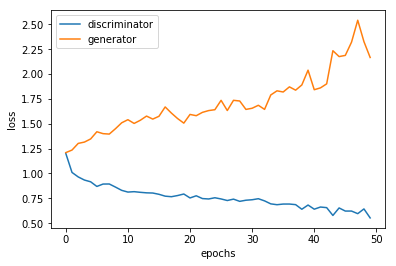

In [77]:
dloss = []
gloss = []
for i in range(m.e):
    dloss.append(np.mean(m.learning_curve[i]["dloss"]))
    gloss.append(np.mean(m.learning_curve[i]["gloss"]))
    
plt.figure()
plt.plot(dloss, label="discriminator")
plt.plot(gloss, label="generator")
plt.legend()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.savefig("figures/learning_curves.png")
plt.show()

# Resulting image

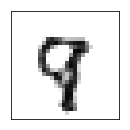

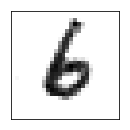

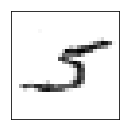

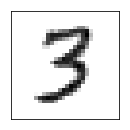

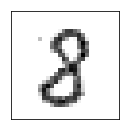

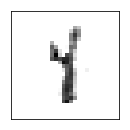

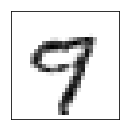

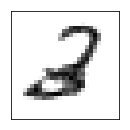

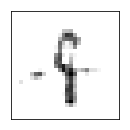

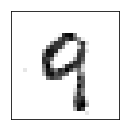

In [78]:
for i in range(10):
    test = m.record["generated"][np.random.randint(50000)][:, :, 0]
    plt.figure(figsize=(2,2))
    plt.imshow(test, cmap="Greys")
    plt.xticks([],[])
    plt.yticks([],[])
    plt.savefig("figures/"+str(i)+".png")
    plt.show()